# test model on test data 
Test the model on the test data and save the results.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
os.environ['MPLCONFIGDIR'] = '/myhome'
from utils.plots import plot_label_distribution_datasets
from utils.helpers_config import set_up_config, save_config, print_config
from utils.test.helpers_testing import get_test_stats_from_model, load_test_dataset, save_test_stats
from utils.plots_test import plots_all_figs_at_test
import matplotlib.pyplot as plt
from utils.test.load_model import get_all_runs, get_loaded_model_and_criterion, get_model_and_model_path
from utils.helpers_mu import get_mus_from_config
from utils.results_analysis.extract_video import download_images, add_files_to_images, save_video
import argparse

In [3]:
run_name = "pleasant-sweep-53"
plot_label_distribution = False
sequencelength_test = None

In [4]:
print(f"Test the model from run '{run_name}' on the test dataset")
local_dataroot = os.path.join(os.environ.get("HOME", os.environ.get("USERPROFILE")),"elects_data")
print("Local dataroot: ", local_dataroot)

# ## Download the model from wandb 
entity, project = "aurenore", "MasterThesis"
runs_df, runs = get_all_runs(entity, project)

# get the run with name:
run_idx = runs_df[runs_df.name == run_name].index[0]
run = runs[run_idx]
run_config = argparse.Namespace(**run.config)
model_artifact, model_path = get_model_and_model_path(run)

# get and save the config
config_path = save_config(model_path, run)
print_config(run)
args  = set_up_config(run_config)
args.dataroot = local_dataroot

# ----------------------------- LOAD DATASET -----------------------------
# Set the sequence length to 150 like in the original paper.
if sequencelength_test is None: 
    sequencelength_test = run_config.sequencelength
test_ds, nclasses, class_names, input_dim = load_test_dataset(args, sequencelength_test)

# ----------------------------- VISUALIZATION: label distribution -----------------------------
if plot_label_distribution:
    datasets = [test_ds]
    sets_labels = ["Test"]
    fig, ax = plt.subplots(figsize=(15, 7))
    fig, ax = plot_label_distribution_datasets(datasets, sets_labels, fig, ax, title='Label distribution', labels_names=class_names)

# ## Load the models and the criterions
mus = get_mus_from_config(run_config)
model, criterion = get_loaded_model_and_criterion(run, nclasses, input_dim, mus=mus)

# ## Test the model on the test dataset
test_stats, stats = get_test_stats_from_model(model, test_ds, criterion, run_config)
print("test_stats:\n", test_stats)
test_stats_path = save_test_stats(model_path, test_stats)


Test the model from run 'pleasant-sweep-53' on the test dataset
Local dataroot:  C:\Users\anyam\elects_data


wandb:   1 of 1 files downloaded.  


config file saved at:  c:\Users\anyam\Desktop\Master_thesis\Code\elects\artifacts\run-qpyr92q5-model.pth-v10\config.json
-------------------------------------------------- Configuration: --------------------------------------------------
loss: daily_reward
alpha: 1
device: cuda
epochs: 100
resume: False
dataset: breizhcrops
epsilon: 10
dataroot: /home/amauron/elects/data/elects_data
patience: 30
snapshot: /home/amauron/elects/data/elects_snapshots/model.pth
batchsize: 256
corrected: True
alpha_decay: [1, 1]
hidden_dims: 64
loss_weight: balanced
left_padding: False
weight_decay: 0
backbonemodel: LSTM
class_weights: [0.04731182754039765, 0.02670983411371708, 0.14316703379154205, 0.01290007308125496, 1, 0.011567785404622557, 0.010797104798257353]
decision_head: day
learning_rate: 0.001
nb_parameters: 66978
sequencelength: 365
validation_set: valid
daily_timestamps: True
day_head_init_bias: 1
extra_padding_list: [0]
original_time_serie_lengths: [102]
start_decision_head_training: 40
------

loading data into RAM: 100%|██████████| 2463/2463 [00:01<00:00, 1453.27it/s]


1555075632 1555075632


loading data into RAM: 100%|██████████| 36915/36915 [00:18<00:00, 1992.03it/s]


class names: ['barley' 'wheat' 'rapeseed' 'corn' 'orchards' 'permanent meadows'
 'temporary meadows']


wandb:   1 of 1 files downloaded.  
c:\Users\anyam\Desktop\Master_thesis\Code\elects\utils\test\load_model.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(run_config.class_weights)


model is loading from:  c:\Users\anyam\Desktop\Master_thesis\Code\elects\artifacts\run-qpyr92q5-model.pth-v10
The model has 66,978 trainable parameters.
weights moved to device cuda
test_stats:
 {'test_loss': 8.182415, 'accuracy': 0.6877952156026208, 'precision': 0.6957806079623582, 'recall': 0.7637586168982391, 'fscore': 0.6789633930781177, 'kappa': 0.6162234117897372, 'elects_earliness': 0.0, 'classification_loss': 8.182415, 'earliness_reward': 0.0, 'harmonic_mean': 0.0}
test_stats saved at  c:\Users\anyam\Desktop\Master_thesis\Code\elects\artifacts\run-qpyr92q5-model.pth-v10\test_stats.json


legend_ax_index 7
fig saved at  c:\Users\anyam\Desktop\Master_thesis\Code\elects\artifacts\run-qpyr92q5-model.pth-v10\class_probabilities_wrt_time_with_mus.png


C:\Users\anyam\AppData\Local\Temp\ipykernel_99324\945101579.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_prob_class.show()


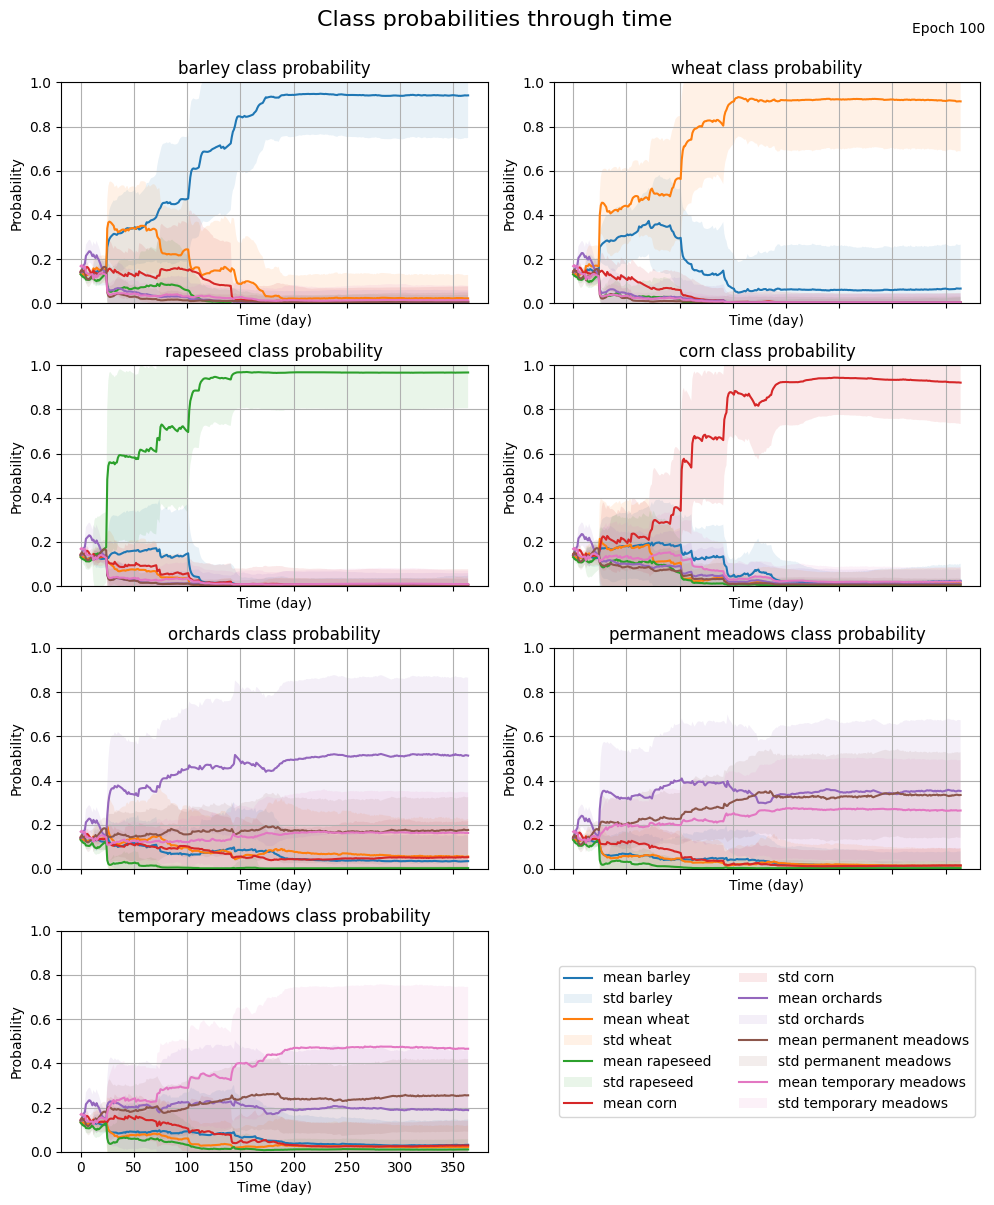

In [27]:
from utils.plots import boxplot_stopping_times, plot_timestamps_left_per_class, create_figure_and_axes
from utils.plots_test import plot_fig_class_prob_wrt_time_with_mus

fig_prob_class, axes_prob_class = create_figure_and_axes(nclasses, n_cols=2)
# check that run_cconfig has p_thresh as attribute 
if not hasattr(run_config, "p_thresh"):
    run_config.p_thresh = None
fig_prob_class, _ = plot_fig_class_prob_wrt_time_with_mus(fig_prob_class, axes_prob_class, \
        stats["class_probabilities"], stats["targets"][:, 0], class_names, mus, run_config.p_thresh, \
        alpha=0.1, epoch=run_config.epochs)   
fig_filename = os.path.join(model_path, "class_probabilities_wrt_time_with_mus.png")
fig_prob_class.savefig(fig_filename)
print("fig saved at ", fig_filename)
fig_prob_class.show()

In [ ]:
# ----------------------------- VISUALIZATION: stopping times and timestamps left-----------------------------
plots_all_figs_at_test(args, stats, model_path, run_config, class_names, nclasses)


In [ ]:

# ----------------------------- VISUALIZATION: videos of the performance during training -----------------------------
videos_names = ["class_probabilities_wrt_time", "boxplot", "timestamps_left_plot"]
for name_image in videos_names:
    download_images(name_image, run, model_path)
    images, images_directory = add_files_to_images(model_path, name_image)
    video_path = save_video(images_directory, images, name_image+"_video.mp4")